<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Logo_UTFSM.png" width="200" alt="utfsm-logo" align="left"/>

# MAT281
### Aplicaciones de la Matemática en la Ingeniería

## Módulo 04
## Clase 02: Regresión Lineal

## Objetivos

* Comprender/recordar regresión lineal.
* Estimar el error al aplicar modelos matemáticos a los datos.
* Introducir la librería `scikit-learn`

## Contenidos
* [Regresión Lineal](#linear_regression)
* [Implementaciones](#implementations)
* [Aplicación](#aplicacion)

<a id='linear_regression'></a>

## Regresión Lineal

Técnica universalmente utilizada y a pesar de su simpletaza, la derivación de este método entrega importantes consideraciones sobre su implementación, sus hipótesis y sus posibles extensiones.

#### Motivación

Por motivos pedagógicos utilizaremos un set de datos que ha sido testeado a lo largo de los años en la literatura, el que consiste en registros de peso del cerebro y cuerpo de distintos mamíferos.

In [1]:
!head data/brain_and_body_weight.txt -n 50

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [2]:
import numpy as np
import pandas as pd
import altair as alt

alt.themes.enable('opaque')  # Para quienes utilizan temas oscuros en Jupyter Lab

ThemeRegistry.enable('opaque')

In [3]:
# Read data
data_txt = np.loadtxt("data/brain_and_body_weight.txt", skiprows=33)
brain_body_df = pd.DataFrame(data_txt[:, [1, 2]], index=data_txt[:, 0].astype(int), columns=["wgt_brain", "wgt_body"])
brain_body_df.head()

,wgt_brain,wgt_body
1,3.385,44.5
2,0.480,15.5
3,1.350,8.1
4,465.000,423.0
5,36.330,119.5


#### Exploración

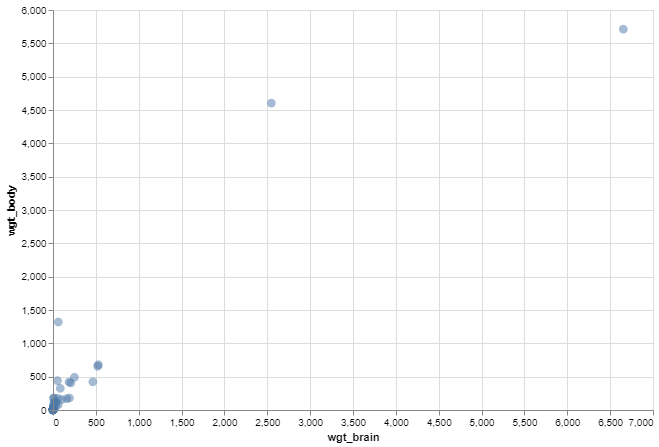

In [4]:
points = alt.Chart(brain_body_df).mark_circle(size=75, opacity=0.5).encode(
    x="wgt_brain:Q",
    y="wgt_body:Q"
).properties(
    width=600,
    height=400
)
#opacity es para marcar mas opacos donde hay mayor densidad
points

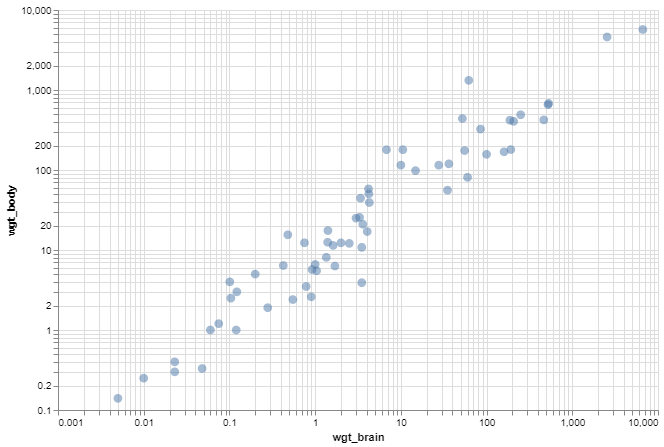

In [5]:
# Logarithmic Scale
log_points = alt.Chart(brain_body_df).mark_circle(size=75, opacity=0.5).encode(
    x=alt.X("wgt_brain:Q", 
          scale=alt.Scale(type="log")),
    y=alt.Y("wgt_body:Q", scale=alt.Scale(type="log"))
).properties(
    width=600,
    height=400
)

log_points

#### Los datos

Supondremos que tenemos $m$ datos. 
Cada dato $x^{(i)}$, $i=1,\dots,$ $m$ tiene $n$ componentes,
$x^{(i)} = (x^{(i)}_1, ..., x^{(i)}_n)$. 

Conocemos además el valor (etiqueta) asociado a $x^{(i)}$ que llamaremos $y^{(i)}$, $i=1,\dots, m$ .

#### Modelo

Nuestra hipótesis de modelo lineal puede escribirse como

$$\begin{aligned}
h_{\theta}(x) &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n \\
          &= \begin{bmatrix}\theta_0 & \theta_1 & \theta_2 & \dots & \theta_n\end{bmatrix} \begin{bmatrix}1 \\ x_1 \\x_2 \\ \vdots \\ x_n\end{bmatrix} \\
          &= \theta^T \begin{bmatrix}1\\x\end{bmatrix} = \begin{bmatrix}1 & x^T\end{bmatrix} \theta \end{aligned}$$

Definiremos $x^{(i)}_0 =1$, de modo que
$h_{\theta}(x^{(i)}) = (x^{(i)})^T \theta $ y buscamos el vector de parámetros
$$\theta = \begin{bmatrix}\theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n\end{bmatrix}$$


Definamos las matrices

$$\begin{aligned}
Y &= \begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}\end{aligned}$$

y

$$\begin{aligned}
X = 
\begin{bmatrix} 
1 & x^{(1)}_1 & \dots & x^{(1)}_n \\ 
1 & x^{(2)}_1 & \dots & x^{(2)}_n \\
\vdots & \vdots & & \vdots \\
1 & x^{(m)}_1 & \dots & x^{(m)}_n \\
\end{bmatrix}
= 
\begin{bmatrix} 
- (x^{(1)})^T - \\ 
- (x^{(2)})^T - \\
\vdots \\
- (x^{(m)})^T - \\
\end{bmatrix}\end{aligned}$$


Luego la evaluación
de todos los datos puede escribirse matricialmente como

$$\begin{aligned}
X \theta &= 
\begin{bmatrix}
1 & x_1^{(1)} & ... & x_n^{(1)} \\
\vdots & \vdots & & \vdots \\
1 & x_1^{(m)} & ... & x_n^{(m)} \\
\end{bmatrix}
\begin{bmatrix}\theta_0 \\ \theta_1 \\ \vdots \\ \theta_n\end{bmatrix} \\
& = 
\begin{bmatrix}
1 \theta_0 + x^{(1)}_1 \theta_1 + ... + x^{(1)}_n \theta_n \\
\vdots \\
1 \theta_0 + x^{(m)}_1 \theta_1 + ... + x^{(m)}_n \theta_n \\
\end{bmatrix} \\
& = 
\begin{bmatrix}
h(x^{(1)}) \\
\vdots \\
h(x^{(m)})
\end{bmatrix}\end{aligned}$$


Nuestro problema es
encontrar un “buen” conjunto de valores $\theta$ de modo que

$$\begin{aligned}
\begin{bmatrix}
h(x^{(1)}) \\
h(x^{(2)}) \\
\vdots \\
h(x^{(m)})
\end{bmatrix}
\approx
\begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}\end{aligned}$$

es decir, que $$X \theta \approx Y$$

Para encontrar el mejor vector $\theta$ podríamos definir una función de costo $J(\theta)$ de la siguiente manera:

$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

<a id='implementations'></a>

## Implementaciones

### Aproximación Ingenieril

¿Cómo podemos resolver el problema
en el menor número de pasos?

Deseamos resolver el sistema $$A \theta = b$$ con
$A \in \mathbb{R}^{m \times n}$ y $m > n$ (La matrix $A$ es skinny).

¿Cómo resolvemos?

Bueno,
si $A \in \mathbb{R}^{m \times n}$, entonces
$A^T \in \mathbb{R}^{n \times m}$ y la multiplicación está bien definida
y obtengo el siguiente sistema lineal, conocido como **Ecuación Normal**:
$n \times n$.
$$(A^T A) \  \theta = A^T b$$ 

Si la matriz $A^T A$ es invertible, el sistema se puede solucionar “sin mayor reparo”. $$\theta = (A^T A)^{-1} A^T b$$

En nuestro caso, obtendríamos $$\theta = (X^T X)^{-1} X^T Y$$ Esta
respuesta, aunque correcta, no admite interpretaciones y no permite
generalizar a otros casos más generales.

En particular...

-   ¿Qué relación tiene con la función de costo (no) utilizada?

-   ¿Qué pasa si $A^T A$ no es invertible?


### Aproximación Machine Learning

¿Cómo podemos obtener una
buena aproximación para $\theta$?

Queremos encontrar $\theta^*$ que minimice $J(\theta)$.

Basta con utilizar una buena rutina de optimización para cumplir con
dicho objetivo.

En particular, una elección natural es tomar la dirección de mayor
descenso, es decir, el método del máximo descenso (gradient descent).

$$\theta^{(n+1)} = \theta^{(n)} - \alpha \nabla_{\theta} J(\theta^{(n)})$$
donde $\alpha >0$ es la tasa de aprendizaje.

En
nuestro caso, puesto que tenemos
$$J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$
se tiene que

$$\begin{aligned}
\frac{\partial J(\theta)}{\partial \theta_k} &=
\frac{\partial }{\partial \theta_k} \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2 \\
&= \frac{1}{2} \sum_{i=1}^{m}  2 \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) \frac{\partial h_{\theta}(x^{(i)})}{\partial \theta_k}  \\
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) x^{(i)}_k\end{aligned}$$


Luego, el algoritmo queda como sigue:
$$\begin{aligned}
\theta^{(n+1)} & = \theta^{(n)} - \alpha \nabla_{\theta} J(\theta^{(n)}) \\\\
\frac{\partial J(\theta)}{\partial \theta_k}
&= \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) x^{(i)}_k\end{aligned}$$

**Observación**: La elección de $\alpha$ es crucial para la convergencia. En
particular, una regla de trabajo es utilizar $0.01/m$. Notar que el parámetro $\alpha$ no es un parámetro del modelo como tal, si no que es parte del algoritmo, este tipo de parámetros se suelen llamar **hyperparameters**. Pudes reconocerlos porque el valor del parámetro es conocido antes de la fase de entranamiento del modelo.


In [6]:
def lms_regression_slow(X, Y, theta, tol=1E-6):
    m, n = X.shape
    converged = False
    alpha = 0.01 / len(Y)
    while not converged:
        gradient = 0.
        for xiT, yi in zip(X, Y):
            xiT = xiT.reshape(1, n)
            hi = np.dot(xiT, theta)
            gradient += (hi - yi) * xiT.T
        new_theta = theta - alpha * gradient
        converged = np.linalg.norm(theta - new_theta) < tol * np.linalg.norm(theta)
        theta = new_theta
    return theta

In [7]:
m = 1000
t = np.linspace(0, 1, m)
x = 2 + 2 * t
y = 300 + 100 * t
X = np.array([np.ones(m), x]).T
Y = y.reshape(m, 1)
theta_0 = np.array([[0.0], [0.0]])

In [8]:
theta_slow = lms_regression_slow(X, Y, theta_0)
print(theta_slow)

[[199.39672176]
 [ 50.19457286]]


Validamos si nuestro resultado es el indicado con una tolerancia dada.

In [9]:
np.allclose(X @ theta_slow, Y, atol=0.5)

True

In [10]:
np.allclose(X @ theta_slow, Y, atol=1e-3)

False

### Implementación Vectorial

**¿Cómo podemos obtener una justificación para la ecuación normal?**

Necesitamos los siguientes ingredientes:

$$\begin{aligned}
\nabla_x &(x^T A x) = A x + A^T x \\ 
\nabla_x &(b^T x) = b \end{aligned}$$

Se tiene

$$\begin{aligned}
J(\theta) 
&= \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2 \\
&= \frac{1}{2} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) \left( h_{\theta}(x^{(i)}) - y^{(i)}\right) \\
&= \frac{1}{2} \left( X \theta - Y \right)^T \left( X \theta - Y \right) \\
&= \frac{1}{2} \left( \theta^T X^T - Y^T \right) \left( X \theta - Y \right) \\
&= \frac{1}{2} \left( \theta^T X^T X \theta - \theta^T X^T Y - Y^T X \theta + Y^T Y \right) \\
&= \frac{1}{2} \left( \theta^T X^T X \theta - 2 (Y^T X) \theta + Y^T Y \right)\end{aligned}$$

Aplicando a cada uno de los términos, obtenemos:

$$\begin{aligned}
\nabla_\theta ( \theta^T X^T X \theta ) &= X^T X \theta + (X^T X)^T \theta \\
& = 2 X^T X \theta\end{aligned}$$

también se tiene

$$\begin{aligned}
\nabla_\theta ( Y^T X \theta  ) &= (Y^T X) ^T\\
&= X^T Y\end{aligned}$$

y por último

$$\begin{aligned}
\nabla_\theta ( Y^T Y  ) = 0\end{aligned}$$

Por lo tanto se tiene que

$$\begin{aligned}
\nabla_\theta J(\theta) 
& = \nabla_\theta  \frac{1}{2} \left( \theta^T X^T X \theta - 2 (Y^T X) \theta + Y^T Y \right) \\
&= \frac{1}{2} ( 2 X^T X \theta - 2 X^T Y + 0 ) \\
&= X^T X \theta - X^T Y \end{aligned}$$


Esto significa que el problema $$\min_\theta J(\theta)$$ se resuelve al
hacer todas las derivadas parciales iguales a cero (ie, gradiente igual
a cero) $$\nabla_\theta J(\theta) = 0$$ lo cual en nuestro caso se
convierte convenientemente a la ecuación normal $$X^T X \theta = X^T Y$$
y se tiene $$\theta = (X^T X)^{-1} X^T Y$$


In [11]:
def lms_regression_fast(X, Y, theta, tol=1E-6):
    converged = False
    alpha = 0.01 / len(Y)
    theta = theta.reshape(X.shape[1], 1)
    A = np.dot(X.T, X)
    b = np.dot(X.T, Y)
    while not converged:
        gradient = np.dot(A, theta) - b
        new_theta = theta - alpha * gradient
        converged = np.linalg.norm(theta - new_theta) < tol * np.linalg.norm(theta)
        theta = new_theta
    return theta

In [12]:
theta_fast = lms_regression_fast(X, Y, theta_0)
print(theta_fast)

[[199.39672176]
 [ 50.19457286]]


Validación

In [13]:
np.allclose(X @ theta_slow, Y, atol=0.5)

True

In [14]:
np.allclose(X @ theta_fast, Y, atol=1e-3)

False

También es posible usar la implementación de resolución de sistemas lineales dispoinible en numpy.

In [15]:
def matrix_regression(X, Y, theta, tol=1E-6):
    A = np.dot(X.T,X)
    b = np.dot(X.T,Y)
    sol = np.linalg.solve(A,b)
    return sol

In [16]:
theta_npsolve = matrix_regression(X, Y, theta_0)
print(theta_npsolve)

[[200.]
 [ 50.]]


### Interpretación Probabilística

Consideremos el modelo lineal

$$ Y = X \theta + \varepsilon $$

donde $\varepsilon$ es un vector de errores aleatorios de media cero y matriz de dispersión $\sigma^2 I$, donde $I$ es la matriz identidad. Es usual añadir el supuesto de normalidad al vector de errores, por lo que se asume que 

$$\varepsilon \sim  \mathcal{N}(0, \sigma^2 I)$$

Cabe destacar que:

-   $\theta$ no es una variable aleatoria, es un parámetro
    (desconocido).
-   $Y \ | \ X; \theta \sim \mathcal{N}(X \theta, \sigma^2 I)$


La función de verosimilitud $L(\theta)$ nos
permite entender que tan probable es encontrar los datos observados,
para una elección del parámetro $\theta$.

$$
L(\theta) = \left( 2 \pi \sigma^2 \right)^{-n/2} \, \exp\left(- \frac{1}{2 \sigma ^2} || Y - X \theta ||^2 \right)
$$

Sea $l(\theta) = \log L(\theta)$ la log-verosimilitud. Luego, ignorando los términos constantes se tiene

$$
l(\theta) = -\frac{n}{2} \log \sigma^2 - \frac{1}{2 \sigma ^2} || Y - X \theta ||^2
$$

Luego, derivando respecto a $\theta$:

$$
\begin{aligned}
\frac{\partial l(\theta)}{\partial \theta}
&= - \frac{1}{2 \sigma ^2} \left( - 2 X^T Y + 2 X^T X \theta \right) \\
&= - \frac{1}{\sigma ^2} \left( X^T Y + X^T X \theta \right) \\
\end{aligned}
$$

Luego podemos usar toda nuestra artillería de optimización despejando $\partial l(\theta) / \partial \theta = 0$ y demostrando que es un máximo.

### Implementación en scikit-learn

_**[Scikit-learn](https://scikit-learn.org/)** Machine Learning in Python_

Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

* Simple and efficient tools for predictive data analysis
* Accesible to everybody, and reusable in various contexts
* Built on `numpy`, `scipy` and `matplotlib`
* Open source, commercially usable - BSD license

Scikit-learn cuenta con enorme cantidad de herramientas de regresión, siendo la regresión lineal la más simple de estas. Ajustar una es tan sencillo como:

In [17]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(X, Y)
theta_sklearn = reg.coef_.T
print(theta_sklearn)

[[200.]
 [ 50.]]


Nota que primero se crea un objeto `LinearRegression` en que se declaran algunos parámetros, por ejemplo, en nuestro caso la matriz de diseño `X` ya posee una columna de intercepto, por lo que no es necesario incluirla en el modelo de scikit-learn. Luego se ajusta el modelo `reg` con el método `fit()`.


#### Benchmark

Implementación simple

In [ ]:
%%timeit
lms_regression_slow(X, Y, theta_0)

In [ ]:
theta_slow

Implementación vectorizada

In [ ]:
%%timeit
lms_regression_fast(X, Y, theta_0)

In [ ]:
theta_fast

Implementación numpy

In [ ]:
%%timeit
matrix_regression(X, Y, theta_0)

In [ ]:
theta_npsolve

Implementación scikit-learn

In [ ]:
%%timeit
LinearRegression(fit_intercept=False).fit(X, Y).coef_.T

In [ ]:
theta_sklearn

Algunos comentarios:

- La implementación simple es **miles de veces** más lenta que la más rápida, que en este caso es la implementación de numpy.
- La implementación de numpy es sin duda la más rápida, pero no es posible utilizarla con matrices singulares.
- Las implementaciones de _gradient descent_ implementadas _from scratch_ no son lo sufiecientemente precisas.
- scikit-learn demora más pues es más flexible, además de realizar validaciones al momento de ajustar los modelos.

#### Aspectos Prácticos

Al realizar regresión, algunos autores indican que es conveniente normalizar/estandarizar los datos, es
decir transformarlos para que tengan una escala común:

-   Utilizando la media y la desviación estándar
    $$\frac{x_i-\overline{x_i}}{\sigma_{x_i}}$$

-   Utilizando mínimos y máximos
    $$\frac{x_i-\min{x_i}}{\max{x_i} - \min{x_i}}$$

**¿Porqué normalizar?**

-   Los valores numéricos poseen escalas de magnitud distintas.
-   Las variables tienen distintos significados físicos.
-   Algoritmos funcionan mejor.
-   Interpretación de resultados es más sencilla.

**Algunos problemas potenciales**
- Normalizar los datos puede producir colinealidad en los datos, produciendo inestabilidad numérica en la implementación.

<a id='application'></a>

## Aplicación

In [ ]:
X_brain = brain_body_df[["wgt_brain"]].values
y_brain = brain_body_df["wgt_body"].values
brain_reg = LinearRegression(fit_intercept=True).fit(X_brain, y_brain)

In [ ]:
reg_df = (
    brain_body_df.loc[
        lambda x: x["wgt_brain"].isin([x["wgt_brain"].min(), x["wgt_brain"].max()])
        , ["wgt_brain"]
    ].assign(regression=lambda x: brain_reg.intercept_ + x["wgt_brain"] * brain_reg.coef_)
)
reg_df

In [ ]:
reg_line = alt.Chart(reg_df).mark_line(color="red", opacity=0.5).encode(
    x=alt.X("wgt_brain:Q"),
    y=alt.Y("regression:Q")
).properties(
    width=600,
    height=400
)
points + reg_line